In [1]:
ls

 Volume in drive C is Windows
 Volume Serial Number is A4C1-0A90

 Directory of c:\Users\Admin\OneDrive\Desktop\UNSW\EzyRemit\EzyAI\Trust Pilot Scraping

07/31/2025  01:57 PM    <DIR>          .
07/31/2025  02:37 PM    <DIR>          ..
07/31/2025  01:57 PM             4,401 bigrams_words.txt
07/28/2025  06:21 PM             5,521 review_counter.py
07/28/2025  11:18 PM             2,883 review_summary.json
07/29/2025  05:36 PM         2,615,494 scraped_trust_pilot.json
08/01/2025  07:52 PM           585,311 Trust_pilot_analysis.ipynb
07/29/2025  05:35 PM            14,275 trust_pilot_scraper.py
               6 File(s)      3,227,885 bytes
               2 Dir(s)  106,373,316,608 bytes free


In [2]:
import json
import re
from collections import Counter

import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# 1. Load data
with open('scraped_trust_pilot.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 2. Flatten into a DataFrame
records = []
for entry in data:
    company = entry['company']
    for rev in entry.get('reviews', []):
        text = rev.get('text', '').strip()
        rating = rev.get('rating')
        if text and rating is not None:
            sentiment = 'positive' if rating >= 4 else 'negative'
            records.append({
                'company': company,
                'text': text,
                'rating': rating,
                'sentiment': sentiment
            })

df = pd.DataFrame(records)

# 3. Segmentation: count comments per app
seg_counts = df.groupby('company').size().rename('num_comments')
print("\n=== Comments per App ===")
print(seg_counts.to_frame())

# 4. Sentiment classification counts per app
class_counts = df.groupby(['company', 'sentiment']).size().unstack(fill_value=0)
print("\n=== Positive vs Negative per App ===")
print(class_counts)

# 5. Extract top words per (app, sentiment)
top_words = []
for (company, sentiment), subset in df.groupby(['company', 'sentiment']):
    all_text = " ".join(subset['text'].str.lower())
    tokens = re.findall(r'\b\w+\b', all_text)
    tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS and len(t) > 1]
    freq = Counter(tokens)
    for word, count in freq.most_common(10):
        top_words.append({
            'company': company,
            'sentiment': sentiment,
            'word': word,
            'count': count
        })

top_df = pd.DataFrame(top_words)
top_df = top_df.sort_values(['company', 'sentiment', 'count'],
                            ascending=[True, True, False])

# 6. Configure pandas to print all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("\n=== Top 10 Words by App & Sentiment ===")
print(top_df.to_string(index=False))



=== Comments per App ===
                      num_comments
company                           
ezyremit.com                    61
moneygram.com                  898
ofx.com                        958
orbitremit.com                 806
remitly.com                    847
riamoneytransfer.com           749
westernunion.com               847
wise.com                       884
worldremit.com                 896
xe.com                         351

=== Positive vs Negative per App ===
sentiment             negative  positive
company                                 
ezyremit.com                 8        53
moneygram.com              196       702
ofx.com                    160       798
orbitremit.com              30       776
remitly.com                103       744
riamoneytransfer.com       135       614
westernunion.com           212       635
wise.com                   144       740
worldremit.com             362       534
xe.com                      47       304

=== Top 10 Words by App

In [3]:
import json
import re
from collections import Counter

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

# 1. Load & flatten
with open('scraped_trust_pilot.json','r',encoding='utf-8') as f:
    data = json.load(f)

records = []
for entry in data:
    comp = entry['company']
    for rev in entry.get('reviews',[]):
        txt = rev.get('text','').strip()
        rating = rev.get('rating')
        if txt and rating is not None:
            sentiment = 'positive' if rating >= 4 else 'negative'
            records.append({'company': comp, 'text': txt, 'sentiment': sentiment})

df = pd.DataFrame(records)

# 2. Helper: get top n‑grams for a list of texts
def top_ngrams(texts, ngram_range=(2,2), top_n=10):
    vect = CountVectorizer(
        ngram_range=ngram_range,
        stop_words='english',
        token_pattern=r'\b\w+\b'
    )
    X = vect.fit_transform(texts)
    sums = X.sum(axis=0).A1
    vocab = vect.get_feature_names_out()
    freq = sorted(zip(vocab, sums), key=lambda x: x[1], reverse=True)
    return freq[:top_n]

# 3. Print top bigrams by (company, sentiment)
for (company, sentiment), group in df.groupby(['company','sentiment']):
    texts = group['text'].str.lower().tolist()
    bigrams = top_ngrams(texts, ngram_range=(2,2), top_n=20)
    print(f"\n--- {company} ({sentiment}) top 10 BIGRAMS ---")
    for phrase, cnt in bigrams:
        print(f"{phrase:30s} {cnt}")

# 4. (Optional) Show concordance for a target word
def show_concordance(texts, word, width=40, max_examples=5):
    joined = " ".join(texts).lower()
    # split into sentences
    sents = re.split(r'(?<=[.!?])\s+', joined)
    examples = [s for s in sents if re.search(rf'\b{word}\b', s)]
    print(f"\nConcordance for “{word}” (first {max_examples}):")
    for s in examples[:max_examples]:
        idx = s.lower().find(word)
        start = max(0, idx-width)
        end = min(len(s), idx+len(word)+width)
        print("…"+ s[start:end].strip() + "…")

# e.g. inspect “money” contexts in negative reviews of ezyremit.com
neg_texts = df[(df.company=='ezyremit.com') & (df.sentiment=='negative')]['text']
show_concordance(neg_texts, 'money')



--- ezyremit.com (negative) top 10 BIGRAMS ---
12 2024                        3
24 hours                       3
bank transfer                  3
received money                 3
western union                  3
12 24                          2
2 weeks                        2
23 12                          2
châu hoàng                     2
extremely slow                 2
holding money                  2
hoàng western                  2
times told                     2
11 12                          1
2 secs                         1
2024 bank                      1
2024 ezyremit                  1
2024 money                     1
24 h                           1
3 days                         1

--- ezyremit.com (positive) top 10 BIGRAMS ---
customer service               11
highly recommend               8
money transfer                 8
exchange rate                  7
good rate                      5
transfer money                 5
fast reliable                  4
good custome

In [4]:
import json
import re
from collections import Counter

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

# 1. Load & flatten
with open('scraped_trust_pilot.json','r',encoding='utf-8') as f:
    data = json.load(f)

records = []
for entry in data:
    comp = entry['company']
    for rev in entry.get('reviews',[]):
        txt = rev.get('text','').strip()
        rating = rev.get('rating')
        if txt and rating is not None:
            sentiment = 'positive' if rating >= 4 else 'negative'
            records.append({'company': comp, 'text': txt, 'sentiment': sentiment})

df = pd.DataFrame(records)

# 2. Print all negative comments by company
neg_df = df[df['sentiment'] == 'negative']
for company, group in neg_df.groupby('company'):
    print(f"\n=== {company} — Negative Comments ({len(group)}) ===")
    for i, txt in enumerate(group['text'], 1):
        print(f"{i}. {txt}")

# (Optionally continue with your n‑gram / concordance analysis…)



=== ezyremit.com — Negative Comments (8) ===
1. It has been more than 8 days, and I still haven't received my money, despite emailing and messaging for support. All EzyRemit does is tell me to wait. I will never use this company's services again. Don't trust their advertisements; be careful—they might be a scam. They are waiting for the exchange rate to rise before transferring your money.
2. Worst service. Holding my money for 7 days and the recipient still has not received the money. I will never use their service again. My friends and my family have the same problem.
3. I am disguted to see 4 star ratings here.It makes me wonder Trust Pilot is trust worthy?Does it help people with up to date information?Ezyremit takes your money and keeps it forever.My current situation as at 23.12.2024, I bank transfer  money from Australia to Viet Nam on 11.12.2024. Ezyremit confirms payment few hours later.Until today, 23.12.2024, the money is still not delivered.Ezyremit website promises 12-24 


ANALYSIS FOR: REMITLY.COM
Total Reviews: 847 | Positive: 744 | Negative: 103


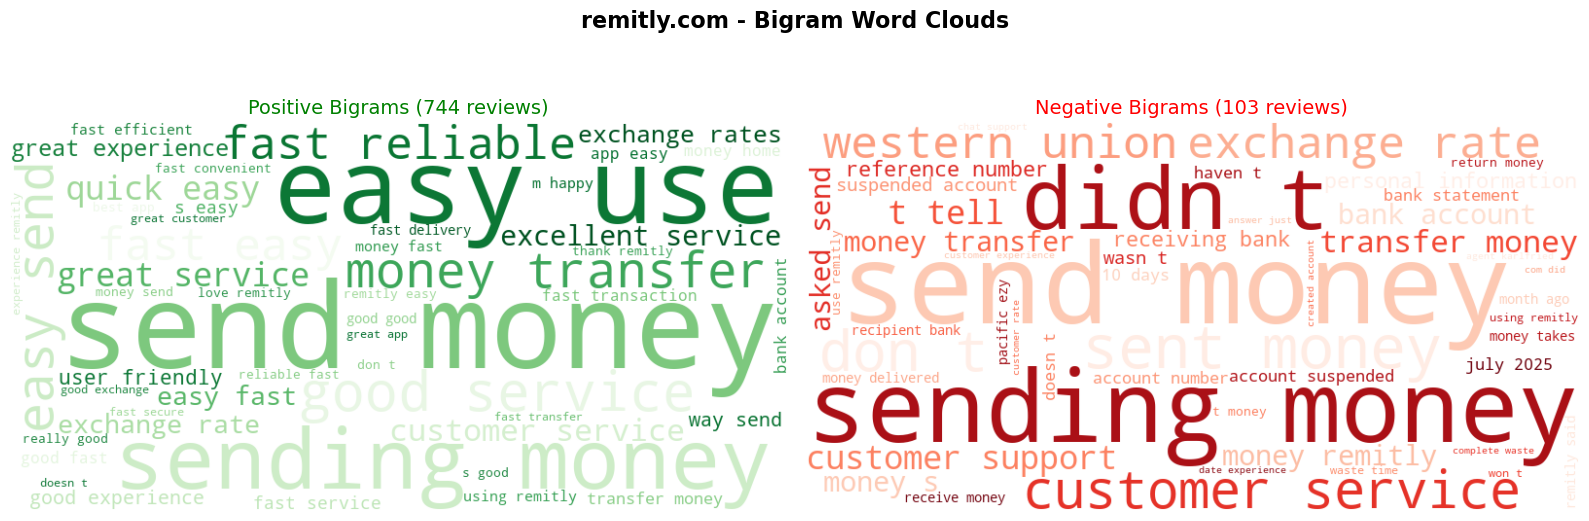


📝 SAMPLE COMMENTS FOR remitly.com
------------------------------------------------------------

🟢 POSITIVE COMMENTS (showing up to 5):
1. ⭐5 - Very good 👍 🏃‍♂️
2. ⭐5 - Ease of use.
3. ⭐5 - Exceptional Money Transfer Service with Remity"Review:I have had a fantastic experience using Remity to send money home. Their service is reliable, efficient, and easy to use, making the entire proces...
4. ⭐5 - Everything was ok, easy to send money everywhere! Low charges too!
5. ⭐5 - Fast and cheap.Much better than my bank.

🔴 NEGATIVE COMMENTS (showing up to 5):
1. ⭐1 - The money wasn’t available until next day
2. ⭐1 - They Took over $270 sent, it shows delivered but was never ever in my bank, went to my bank and they showed me that it never delivered, called remitly and they confirmed it was sent, later they lied i...
3. ⭐1 - I used Remitly to send funds to a tour company, expecting a quick and reliable transaction. Unfortunately, it has been over four days, and the money still has not been deli

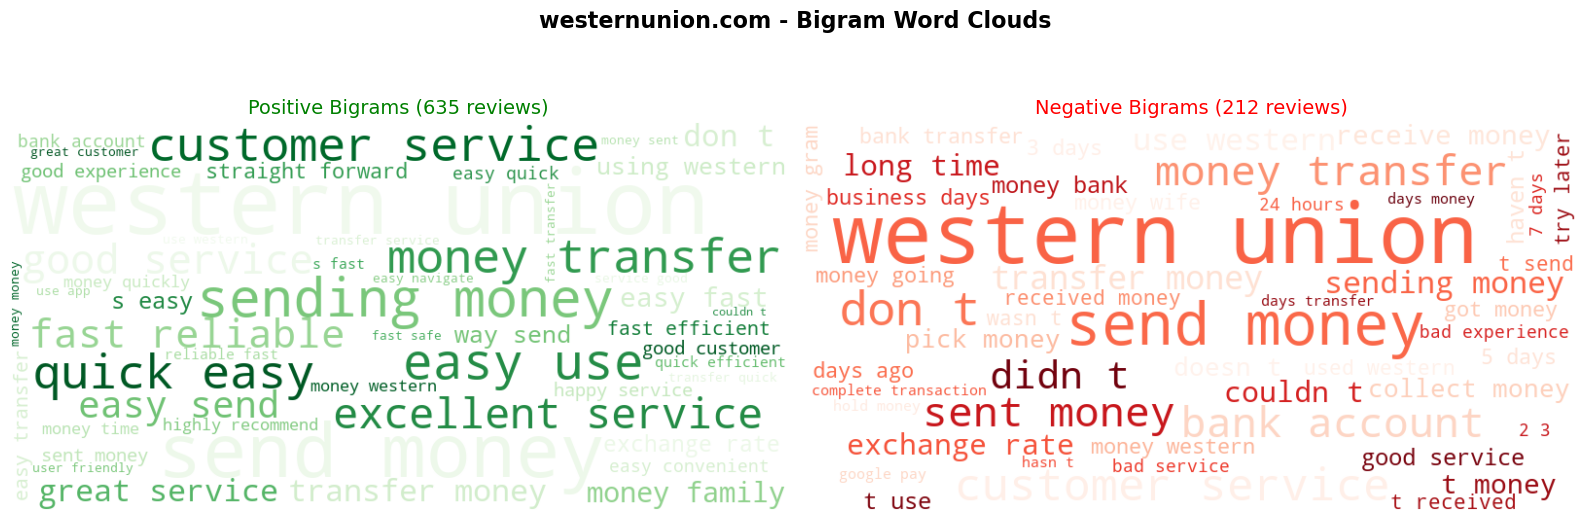


📝 SAMPLE COMMENTS FOR westernunion.com
------------------------------------------------------------

🟢 POSITIVE COMMENTS (showing up to 5):
1. ⭐5 - I'm using Western Union on a regular basis and I'm very pleased with the service. Efficient, safe and secure.
2. ⭐5 - Outstanding Service
3. ⭐5 - I have used this service a few times. Never had any issues. Very good level of communication from sending to reciever collection.
4. ⭐5 - It was great
5. ⭐5 - They're very fast good pricing Been using them for almost 10 years Thank you very much for your support That's all I have to say for now

🔴 NEGATIVE COMMENTS (showing up to 5):
1. ⭐2 - Your service fees and exchange rates are incredibly high and extortionate. I’ll never use you again. You are nothing but thieves
2. ⭐2 - I sent the money direct to the Bank account of my sister as I always did, but she did not receive it. Instead she had received a message via viber on her phone that she needs to pick it up from Wester...
3. ⭐3 - When I tried

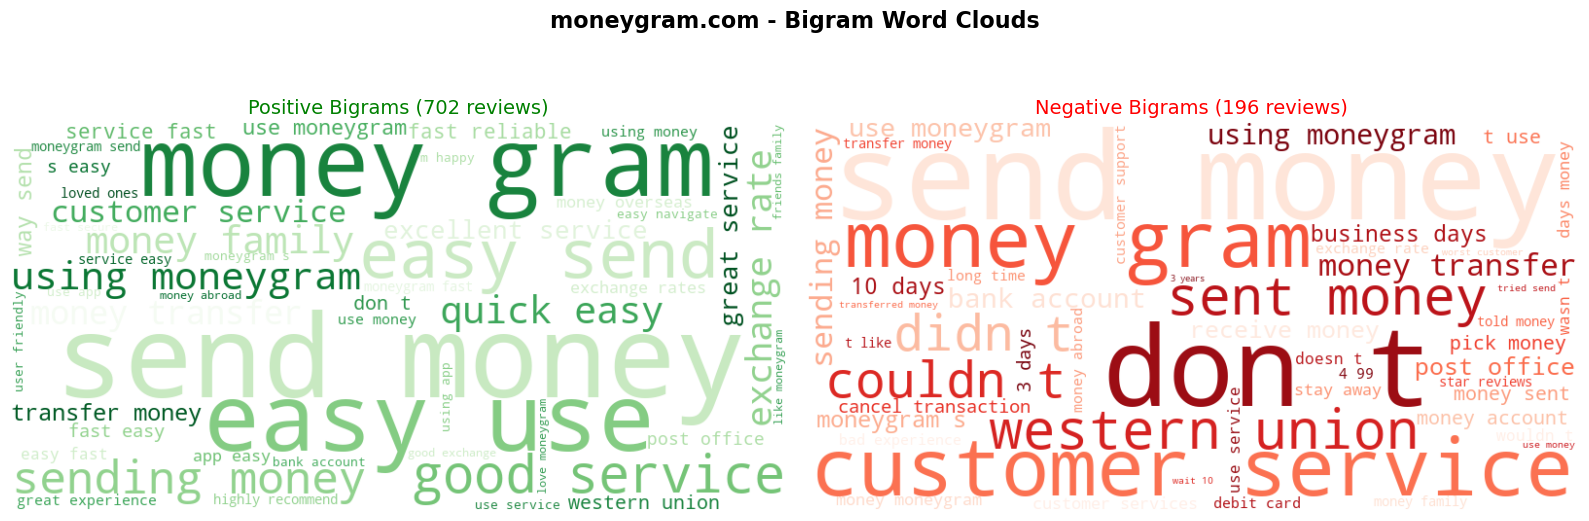


📝 SAMPLE COMMENTS FOR moneygram.com
------------------------------------------------------------

🟢 POSITIVE COMMENTS (showing up to 5):
1. ⭐5 - MoneyGram makes it easy and affordable to send money to family and friends.
2. ⭐5 - I send money to my family in the Philippines regularly. For years I used Xoom and paid a high transfer rate as well as taking days to process, due to time differences, pickup at one if the pawn shops....
3. ⭐5 - Money Gram  is very useful tool for money transferring .I recommend, It is the best  service for theirs customers.
4. ⭐5 - Thank you. ...................................................
5. ⭐4 - The transaction time process was good, your money is safe and secured which’s important.

🔴 NEGATIVE COMMENTS (showing up to 5):
1. ⭐3 - Money gram was out of service for few months I was disappointed we didn’t have no reason why the service wasn’t working at that time the rates was high and that was a lost on my side because I had to ...
2. ⭐1 - Moneygram no mo

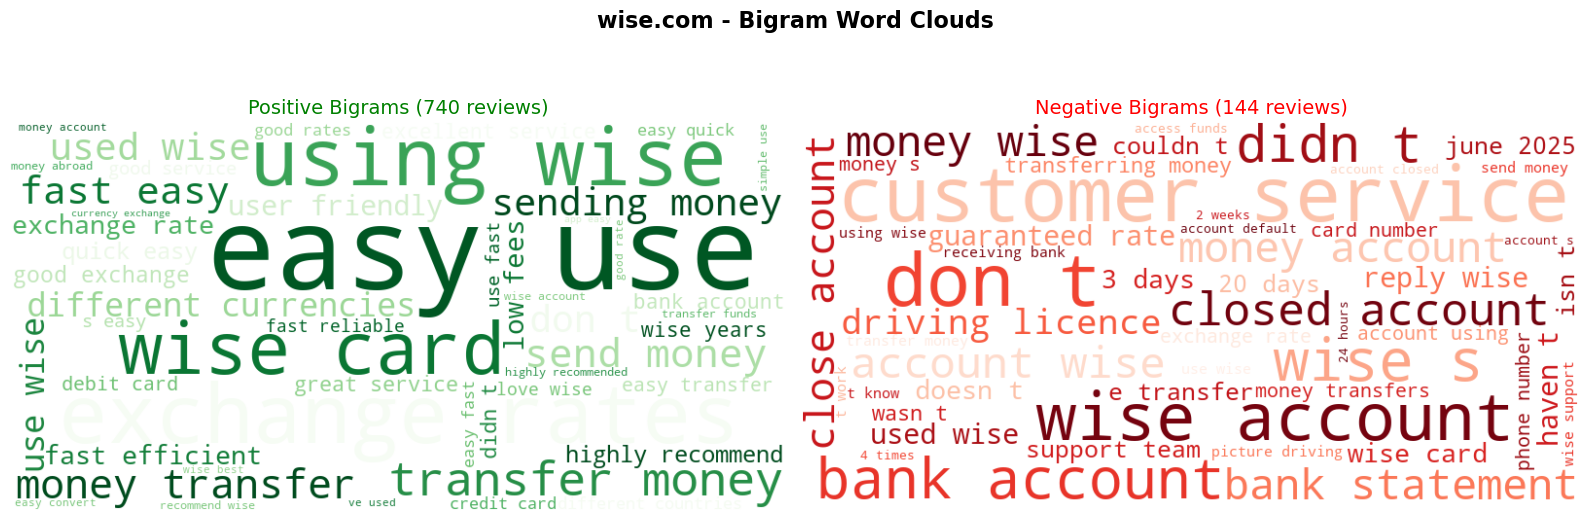


📝 SAMPLE COMMENTS FOR wise.com
------------------------------------------------------------

🟢 POSITIVE COMMENTS (showing up to 5):
1. ⭐5 - Fast and secure: international transfers with Wise, no surprises or hidden fees. Highly recommended.
2. ⭐5 - Brilliant as always. This time I made an international bank transfer. It was easy to set up and the money arrived later the same day. I always use Wise as the site is easy to use and they are trustwor...
3. ⭐5 - Easy to use and excellent Exchange rates.
4. ⭐5 - It is so easy to use, as simple as that, your money is in your account within seconds without expensive costs, and they tell you what the costs are before you have to commit. I use them on a monthly b...
5. ⭐5 - Really like Wise 👍 So fast transfers,  no fees between own accounts. Easy to send to another institution and very good protection of account. All the  time when I travel to another country,  Wise ask ...

🔴 NEGATIVE COMMENTS (showing up to 5):
1. ⭐3 - It's a great online bank

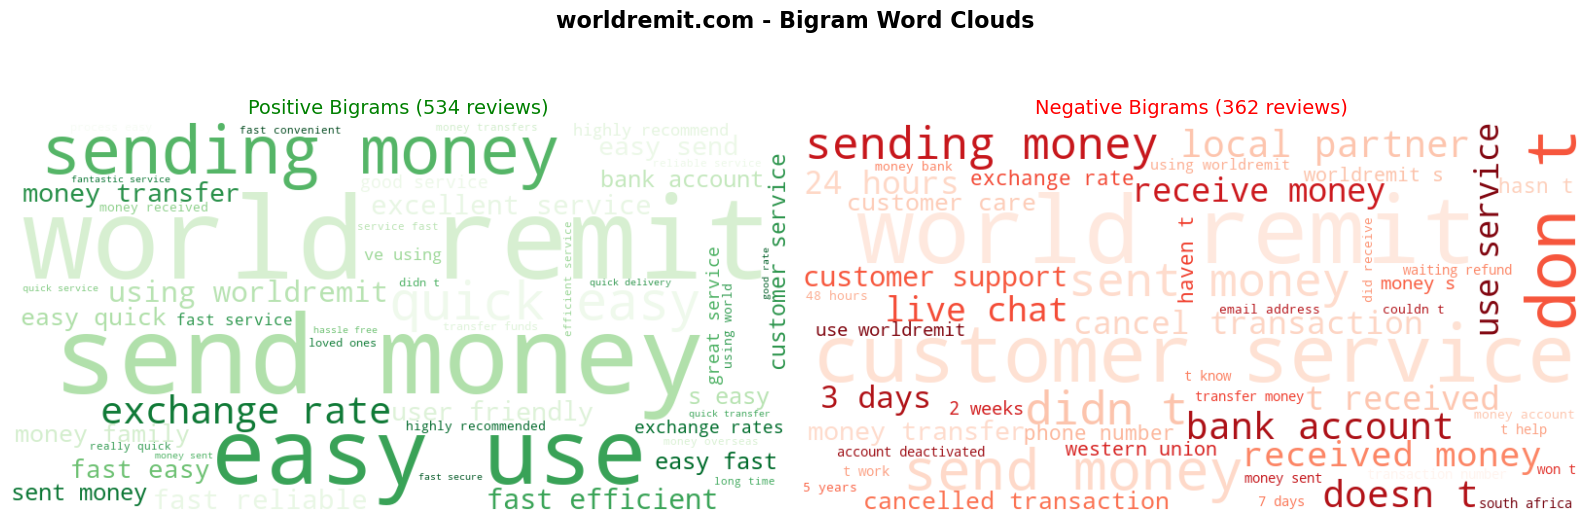


📝 SAMPLE COMMENTS FOR worldremit.com
------------------------------------------------------------

🟢 POSITIVE COMMENTS (showing up to 5):
1. ⭐5 - I had an amazing experience using WorldRemit for money transfers! They offer the best rates on the market, and the process was quick and easy. My recipient received the funds almost instantly. Highly ...
2. ⭐4 - Edit: they refunded all my money so its all good now though it took weeks.Terrible company they take forever to deliver money and when you cancel you wont get your money back, always use a credit card...
3. ⭐5 - Very straightforward, low charges, good exchange rate and well informed on transaction progress.
4. ⭐5 - Perfect service 👌🏾
5. ⭐5 - Send some money to my family and they received within minutes i was taking to them and doing the transaction at the same time very happy with WorldRemit

🔴 NEGATIVE COMMENTS (showing up to 5):
1. ⭐1 - Very poor!!! Lying about where the money would land. On the website/app says it will land on hor

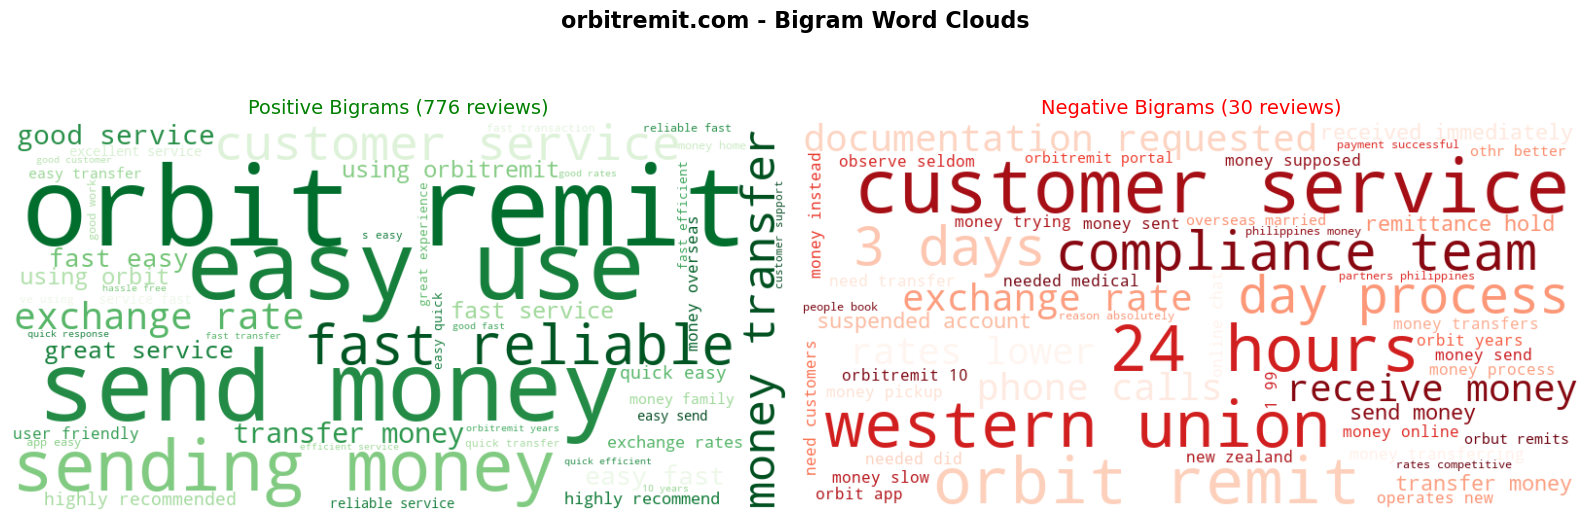


📝 SAMPLE COMMENTS FOR orbitremit.com
------------------------------------------------------------

🟢 POSITIVE COMMENTS (showing up to 5):
1. ⭐5 - Your company does a great job and I was impressed when I had a problem with my app, you were easy to understand and you were very helpful, I would like to thank you.
2. ⭐5 - Good service, easy to deal and so quick
3. ⭐5 - The app is easy to use and I can receive the money quickly via app.
4. ⭐5 - Been using this site for a few years now with no hiccups at all. Easy to follow and use
5. ⭐5 - Best money remittance for me they replied fast if you got some mistakes and solve it in a day im enjoying using there apps for so far .

🔴 NEGATIVE COMMENTS (showing up to 5):
1. ⭐1 - Bad experience today. My husband send money from his account  to my father yesterday 5pm  my father haven't received yet. Planning to switch to othr better options
2. ⭐1 - They say it only takes minutes but first you need to transfer into Orbut remits accounts and wait till 

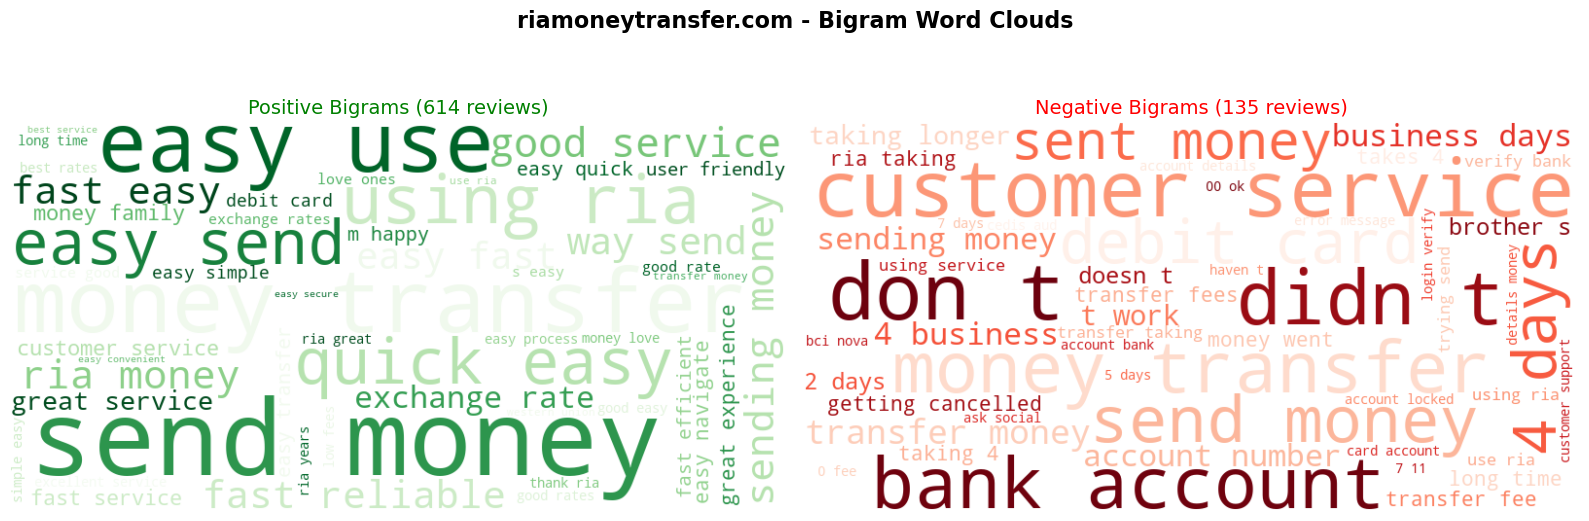


📝 SAMPLE COMMENTS FOR riamoneytransfer.com
------------------------------------------------------------

🟢 POSITIVE COMMENTS (showing up to 5):
1. ⭐5 - Using Ria is quick and easy and they have the best rates compare to other places.
2. ⭐5 - They have very reliable and quick delivery
3. ⭐5 - Really it is excellent money transfer , and at lowest rate 👍👍
4. ⭐5 - Excellent money transfer company.  Prompt delivery money to destination assigned.
5. ⭐5 - This company is the easiest and flawless way to send money to the Phillipines.

🔴 NEGATIVE COMMENTS (showing up to 5):
1. ⭐1 - App is dead slow. The transfer is taking longer times now a days. Several days upto a week.
2. ⭐1 - Sometimes it doesn't give proper error messages for unsuccessful. but just give internal policies.
3. ⭐1 - transfer doesnt happen quickly. for quick transfer you ask extra money which is totally wrong.
4. ⭐3 - I always sent money to Indonesia. Previously the transfer time was fast and receiver can receive within 2 day

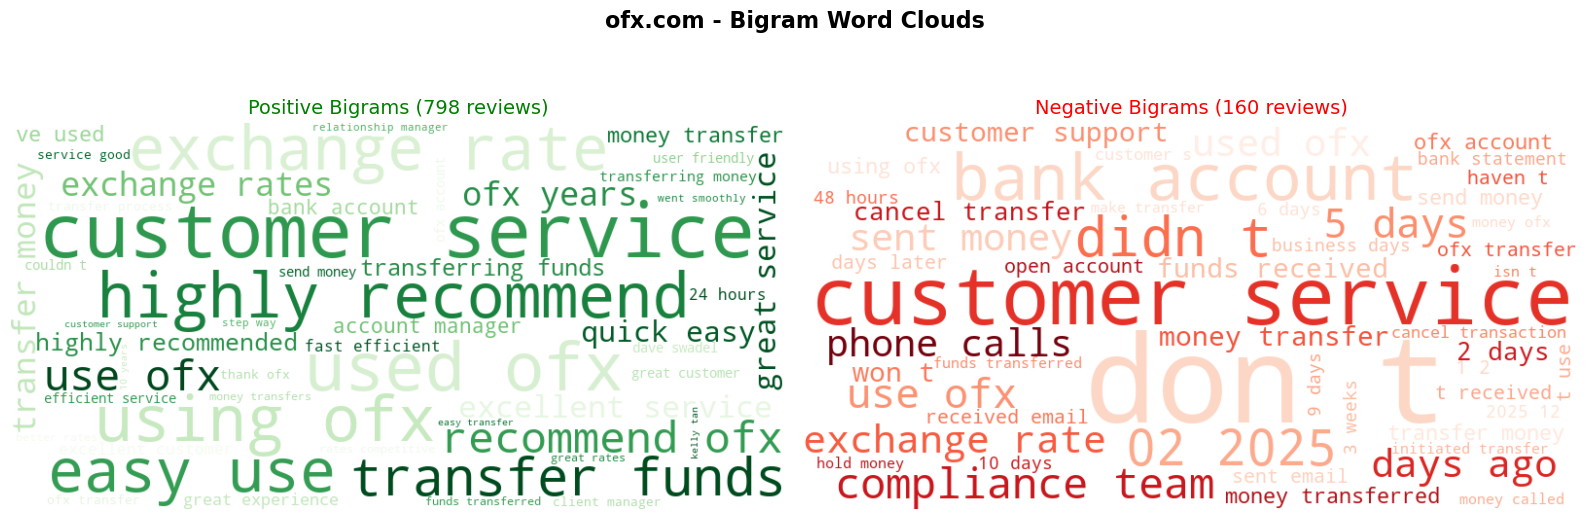


📝 SAMPLE COMMENTS FOR ofx.com
------------------------------------------------------------

🟢 POSITIVE COMMENTS (showing up to 5):
1. ⭐5 - Very user friendly.Very curteous staff.Great rates, best in the business!
2. ⭐5 - Marco and Alexander were incredibly helpful and clear, and assisted me with transferring money from USD in the US to GBP in the UK. They clearly laid out the required documents and responded promptly,...
3. ⭐5 - Bernadene Leeuw--Bernadene has been fantastic helping me navigate my way through setting up  a new OFX account with the ability to handle future Australian share and dividend transactions via Link Mar...
4. ⭐5 - We struggled at first , then went onto the website and asked what to do, and within minutes, the instructions came up. Brilliant help. All done in 5 mins 🙌
5. ⭐5 - Sonja is my client manager and she was exceptional in helping me navigate my tight exchange deadlines. She was courteous and polite, highly professional. I was initially unsure about OFX aft

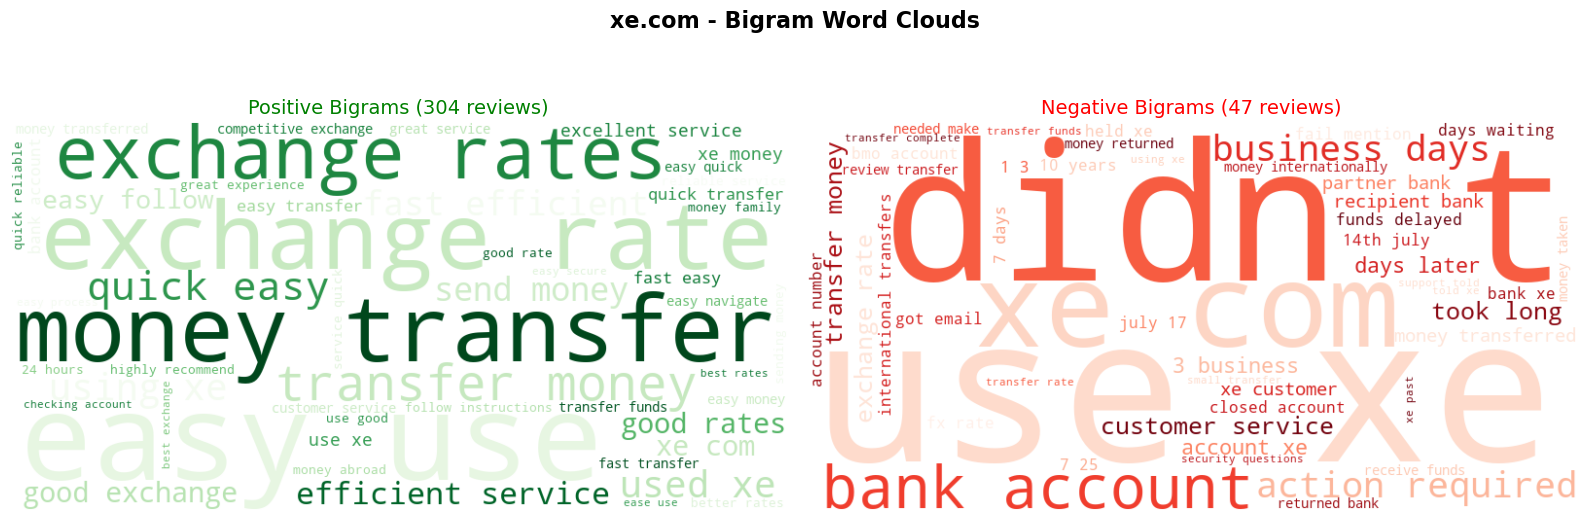


📝 SAMPLE COMMENTS FOR xe.com
------------------------------------------------------------

🟢 POSITIVE COMMENTS (showing up to 5):
1. ⭐5 - Introduced to this website by a friend, no fees compared to the other website I used for years, quick and easy to register an account, user friendly website
2. ⭐5 - Safe secure and quick
3. ⭐5 - No problems, very fast efficient service.
4. ⭐4 - It was easy to make the transfer, although it did take a bit longer than I expected.
5. ⭐5 - Not only fast and efficient, but also helpful in case of problèms

🔴 NEGATIVE COMMENTS (showing up to 5):
1. ⭐1 - This is the second time I've tried to use XE and its failed, not just failed, but support told me its gone and will be with the recipient any day now. After 14 days of waiting, its been returned. Seri...
2. ⭐2 - I initiated the contract on Tue, money was transferred and confirmed on Wed. Final transaction to the client did not occur until Fri. Normally this will happen on the same day instantly. I was very

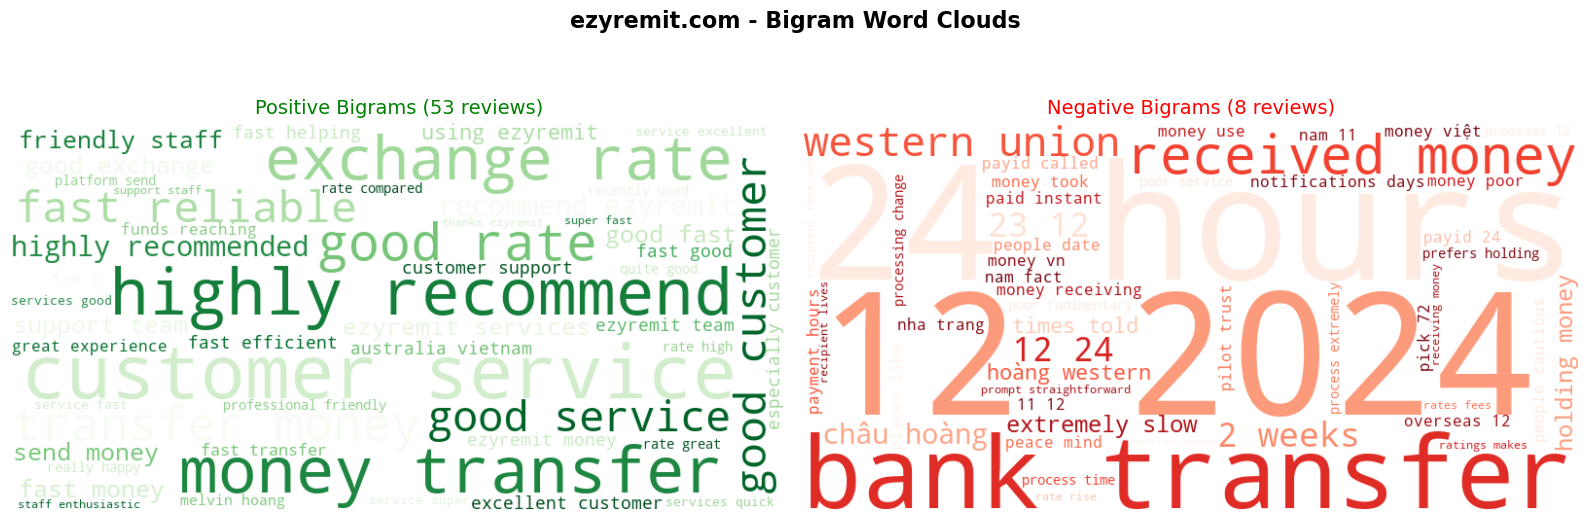


📝 SAMPLE COMMENTS FOR ezyremit.com
------------------------------------------------------------

🟢 POSITIVE COMMENTS (showing up to 5):
1. ⭐5 - Not sure how it be for other people, but lucky for us, no delays or problems with Ezyremit so far. My parents almost used their platform to send me money for living, and everything smooth until now.
2. ⭐5 - Good service, quick response. Have been using this service couple time they are doing great job . Thank you
3. ⭐5 - Staff was friendly and helpful. Money transfer was fast and efficient. Highly recommended for anyone that want to transfer their money overseas safely.
4. ⭐5 - fast reliable service . everyone should try it
5. ⭐4 - Value for money. Excellent customer service and fast transac

🔴 NEGATIVE COMMENTS (showing up to 5):
1. ⭐1 - Worst service. Holding my money for 7 days and the recipient still has not received the money. I will never use their service again. My friends and my family have the same problem.
2. ⭐2 - People should be ca

In [5]:
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Load data
with open('scraped_trust_pilot.json','r',encoding='utf-8') as f:
    data = json.load(f)

records = []
for entry in data:
    comp = entry['company']
    for rev in entry.get('reviews',[]):
        txt = rev.get('text','').strip()
        rating = rev.get('rating')
        if txt and rating is not None:
            sentiment = 'positive' if rating >= 4 else 'negative'
            records.append({'company': comp, 'text': txt, 'sentiment': sentiment, 'rating': rating})

df = pd.DataFrame(records)

# Function to get bigrams for word cloud
def get_bigrams_for_wordcloud(texts):
    vect = CountVectorizer(
        ngram_range=(2,2),
        stop_words='english',
        token_pattern=r'\b\w+\b',
        max_features=100
    )
    X = vect.fit_transform(texts)
    sums = X.sum(axis=0).A1
    vocab = vect.get_feature_names_out()
    bigram_freq = dict(zip(vocab, sums))
    return bigram_freq

# Create visualizations for each company
companies = df['company'].unique()

for company in companies:
    company_data = df[df['company'] == company]
    
    print(f"\n{'='*80}")
    print(f"ANALYSIS FOR: {company.upper()}")
    print(f"{'='*80}")
    
    # Get positive and negative data
    pos_data = company_data[company_data['sentiment'] == 'positive']
    neg_data = company_data[company_data['sentiment'] == 'negative']
    
    print(f"Total Reviews: {len(company_data)} | Positive: {len(pos_data)} | Negative: {len(neg_data)}")
    
    # Create word clouds for bigrams
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{company} - Bigram Word Clouds', fontsize=16, fontweight='bold')
    
    # Positive bigrams word cloud
    if len(pos_data) > 0:
        pos_texts = pos_data['text'].str.lower().tolist()
        pos_bigrams = get_bigrams_for_wordcloud(pos_texts)
        
        if pos_bigrams:
            wc_pos = WordCloud(width=800, height=400, background_color='white', 
                              colormap='Greens', max_words=50).generate_from_frequencies(pos_bigrams)
            axes[0].imshow(wc_pos, interpolation='bilinear')
            axes[0].set_title(f'Positive Bigrams ({len(pos_data)} reviews)', fontsize=14, color='green')
            axes[0].axis('off')
        else:
            axes[0].text(0.5, 0.5, 'No bigrams found', ha='center', va='center', transform=axes[0].transAxes)
            axes[0].set_title(f'Positive Bigrams ({len(pos_data)} reviews)', fontsize=14, color='green')
            axes[0].axis('off')
    else:
        axes[0].text(0.5, 0.5, 'No positive reviews', ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('Positive Bigrams (0 reviews)', fontsize=14, color='green')
        axes[0].axis('off')
    
    # Negative bigrams word cloud
    if len(neg_data) > 0:
        neg_texts = neg_data['text'].str.lower().tolist()
        neg_bigrams = get_bigrams_for_wordcloud(neg_texts)
        
        if neg_bigrams:
            wc_neg = WordCloud(width=800, height=400, background_color='white', 
                              colormap='Reds', max_words=50).generate_from_frequencies(neg_bigrams)
            axes[1].imshow(wc_neg, interpolation='bilinear')
            axes[1].set_title(f'Negative Bigrams ({len(neg_data)} reviews)', fontsize=14, color='red')
            axes[1].axis('off')
        else:
            axes[1].text(0.5, 0.5, 'No bigrams found', ha='center', va='center', transform=axes[1].transAxes)
            axes[1].set_title(f'Negative Bigrams ({len(neg_data)} reviews)', fontsize=14, color='red')
            axes[1].axis('off')
    else:
        axes[1].text(0.5, 0.5, 'No negative reviews', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Negative Bigrams (0 reviews)', fontsize=14, color='red')
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Show sample comments
    print(f"\n📝 SAMPLE COMMENTS FOR {company}")
    print("-" * 60)
    
    # Positive sample comments
    if len(pos_data) > 0:
        print(f"\n🟢 POSITIVE COMMENTS (showing up to 5):")
        sample_pos = pos_data.sample(min(5, len(pos_data)), random_state=42)
        for i, (_, row) in enumerate(sample_pos.iterrows(), 1):
            print(f"{i}. ⭐{row['rating']} - {row['text'][:200]}{'...' if len(row['text']) > 200 else ''}")
    else:
        print(f"\n🟢 POSITIVE COMMENTS: No positive reviews found")
    
    # Negative sample comments
    if len(neg_data) > 0:
        print(f"\n🔴 NEGATIVE COMMENTS (showing up to 5):")
        sample_neg = neg_data.sample(min(5, len(neg_data)), random_state=42)
        for i, (_, row) in enumerate(sample_neg.iterrows(), 1):
            print(f"{i}. ⭐{row['rating']} - {row['text'][:200]}{'...' if len(row['text']) > 200 else ''}")
    else:
        print(f"\n🔴 NEGATIVE COMMENTS: No negative reviews found")
    
    print("\n" + "="*80)